# Forecasting con yfinance + SARIMAX/ARIMA + Optuna (afinación de hiperparámetros)

Este cuaderno descarga **el máximo histórico disponible** desde Yahoo Finance (vía `yfinance`) en el **intervalo que elijas** (por ejemplo `1h`, `1d`, etc.), entrena **ARIMA / SARIMAX**, usa **Optuna** para afinar hiperparámetros y evalúa con métricas frecuentemente usadas en el SOTA:

- **sMAPE**, **MASE**, **MAPE**, **MAE**, **RMSE**
- **Pinball Loss** para cuantiles \(q\in\{0.1,0.5,0.9\}\)
- **Cobertura** de intervalos de predicción

> Nota: Yahoo limita el histórico de datos **intradía**. Implementamos **descarga por ventanas** para obtener todo lo posible (p. ej., ~730 días para `60m/1h`, ~60 días para `2m/5m/15m/30m/90m`, ~7 días para `1m`). Para diarios (`1d`) usamos `period="max"`.


## 1) Instalación de dependencias

Ejecuta esta celda una vez para instalar/actualizar paquetes necesarios.


In [ ]:

#!pip -q install yfinance optuna statsmodels matplotlib pandas numpy tqdm pydantic<2

The system cannot find the file specified.


## 2) Importaciones y configuración

In [ ]:
import warnings, time, math, sys, os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yfinance as yf
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.figsize": (12,4), "axes.grid": True})

SEED = 2025
optuna.logging.set_verbosity(optuna.logging.WARNING)
rng = np.random.default_rng(SEED)

print("Versiones:")
import importlib
for lib in ["pandas","numpy","yfinance","optuna","statsmodels"]:
    m = importlib.import_module(lib)
    print(f"  {lib:<12} {getattr(m,'__version__','unknown')}")


c:\Users\Administrator\Desktop\PROYECTOS\FORECASTING\FORECASTING\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Versiones:
  pandas       2.3.2
  numpy        2.3.2
  yfinance     0.2.65
  optuna       4.5.0
  statsmodels  0.14.5


## 3) Parámetros de entrada

- `TICKER`: símbolo (ej. `AAPL`, `MSFT`, `BTC-USD`, `^GSPC`).
- `INTERVAL`: uno de `["1m","2m","5m","15m","30m","60m","90m","1h","1d","5d","1wk","1mo","3mo"]`.
- `H`: horizonte de predicción (número de pasos futuros).
- `MODEL_TYPE`: `"sarimax"` (estacional) o `"arima"` (no estacional).
- `N_TRIALS`: número de pruebas de Optuna (más alto = mejor búsqueda, pero más lento).


In [ ]:
# === Configura aquí ===
TICKER = "BTC-USD"       # ejemplo: "AAPL", "MSFT", "BTC-USD"
INTERVAL = "1d"       # "1m","5m","15m","30m","60m","90m","1h","1d","1wk","1mo"
H = 30               # horizonte de predicción
MODEL_TYPE = "arima"  # "sarimax" (con estacionalidad) o "arima" (sin)
N_TRIALS = 10          # Optuna trials (sube a 50-100+ si tienes tiempo)
VERBOSE = True


## 4) Descarga robusta de datos (máximo histórico)

Para `1d` usamos `period="max"`. Para intervalos intradía, Yahoo impone límites. Descargamos por **ventanas** consecutivas con tamaños apropiados y unimos los resultados evitando duplicados.


In [4]:
def _intraday_window_days(interval: str) -> int:
    """Devuelve el tamaño de ventana (en días) recomendado para descargar intradía."""
    i = interval.lower()
    if i in ["1m"]:
        return 7
    if i in ["2m","5m","15m","30m","90m"]:
        return 60
    if i in ["60m","1h"]:
        return 730  # ~2 años
    # Para otros, usar 60 por defecto
    return 60

def _normalize_interval(interval: str) -> str:
    """Normaliza variantes comunes (e.g., '1h' -> '60m')."""
    i = interval.lower()
    return "60m" if i in ["1h","60m"] else i

def download_yf_max(ticker: str, interval: str = "1d", auto_adjust=True, back_to="1900-01-01") -> pd.DataFrame:
    """
    Descarga lo máximo posible de histórico para el intervalo dado.
    - Para '1d' (y mayores) usa period='max' directamente.
    - Para intradía, hace 'chunking' por ventanas para esquivar límites.
    Retorna DataFrame con índice DateTime y columnas OHLCV.
    """
    interval = _normalize_interval(interval)
    intraday = interval not in ["1d","5d","1wk","1mo","3mo"]
    if not intraday:
        df = yf.download(ticker, period="max", interval=interval, auto_adjust=auto_adjust, progress=False)
        if df is None or df.empty:
            raise ValueError("No se obtuvieron datos (intervalo diario o mayor).")
        return df.dropna().sort_index()

    # Intradía: descargar por ventanas
    win_days = _intraday_window_days(interval)
    start = pd.Timestamp(back_to, tz="UTC").tz_convert(None)
    end_cap = pd.Timestamp.utcnow().tz_convert(None)

    frames = []
    cur_start = start
    pbar = tqdm(total=(end_cap - start).days, desc=f"Descargando {ticker} {interval} por ventanas", disable=False)
    while cur_start < end_cap:
        cur_end = min(cur_start + pd.Timedelta(days=win_days), end_cap)
        try:
            part = yf.download(
                ticker, interval=interval, start=cur_start.tz_localize(None), end=cur_end.tz_localize(None),
                auto_adjust=auto_adjust, progress=False, threads=True
            )
        except Exception as e:
            time.sleep(1.0)
            part = yf.download(
                ticker, interval=interval, start=cur_start.tz_localize(None), end=cur_end.tz_localize(None),
                auto_adjust=auto_adjust, progress=False, threads=True
            )
        if part is not None and not part.empty:
            frames.append(part)
        # avanzar
        cur_start = cur_end + pd.Timedelta(seconds=1)
        pbar.update(min(win_days, max(0, (end_cap - (cur_start - pd.Timedelta(seconds=1))).days)))
        time.sleep(0.2)
    pbar.close()

    if not frames:
        raise ValueError("No se obtuvieron datos intradía (posible restricción del activo/intervalo).")

    df = pd.concat(frames, axis=0)
    df = df[~df.index.duplicated(keep="last")]
    df = df.sort_index()
    return df.dropna(how="any")


## 5) Métricas SOTA frecuentes

Incluimos:

- **MAE**, **RMSE**, **MAPE** (con epsilon), **sMAPE**
- **MASE** (escala por naive estacional; si no hay historia suficiente, usa diferencias)
- **Pinball Loss** para cuantiles (0.1, 0.5, 0.9)
- **Cobertura** de intervalos de predicción (cuando el modelo los da)


In [5]:
def mae(y, yhat):
    return float(np.mean(np.abs(y - yhat)))

def rmse(y, yhat):
    return float(np.sqrt(np.mean((y - yhat)**2)))

def mape(y, yhat, eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    return float(np.mean(np.abs((y - yhat) / np.clip(np.abs(y), eps, None))) * 100.0)

def smape(y, yhat, eps=1e-8):
    y = np.asarray(y); yhat = np.asarray(yhat)
    denom = (np.abs(y) + np.abs(yhat)) / 2.0
    denom = np.clip(denom, eps, None)
    return float(np.mean(np.abs(y - yhat) / denom) * 100.0)

def mase(y_train, y_test, yhat_test, seasonality: int = 1, eps=1e-8):
    y_train = np.asarray(y_train); y_test = np.asarray(y_test); yhat_test = np.asarray(yhat_test)
    if seasonality < 1 or len(y_train) <= seasonality:
        scale = np.mean(np.abs(np.diff(y_train))) if len(y_train) > 1 else 1.0
    else:
        scale = np.mean(np.abs(y_train[seasonality:] - y_train[:-seasonality]))
    scale = max(scale, eps)
    return float(np.mean(np.abs(y_test - yhat_test)) / scale)

def pinball_loss(y, yhat_q, q: float):
    y = np.asarray(y); yhat_q = np.asarray(yhat_q)
    diff = y - yhat_q
    return float(np.mean(np.maximum(q*diff, (q-1)*diff)))

def summarize_metrics(y_train, y_test, mean_forecast, lower=None, upper=None, seasonality:int=1):
    metrics = {
        "MAE": mae(y_test, mean_forecast),
        "RMSE": rmse(y_test, mean_forecast),
        "MAPE%": mape(y_test, mean_forecast),
        "sMAPE%": smape(y_test, mean_forecast),
        "MASE": mase(y_train, y_test, mean_forecast, seasonality=seasonality)
    }
    # Pinball at common quantiles using mean as proxy if quantiles not provided
    for q in [0.1, 0.5, 0.9]:
        metrics[f"Pinball@{q}"] = pinball_loss(y_test, mean_forecast, q) if (lower is None or upper is None) else None

    coverage = None
    if lower is not None and upper is not None:
        inside = (np.asarray(y_test) >= np.asarray(lower)) & (np.asarray(y_test) <= np.asarray(upper))
        coverage = float(np.mean(inside))
    metrics["PI_coverage"] = coverage
    return metrics


## 6) Utilidades: estacionalidad y función de entrenamiento/validación

- Mapeamos una estacionalidad por **intervalo** (heurística común).
- Definimos un **objetivo de Optuna** que entrena SARIMA(X) y evalúa con sMAPE en una validación temporal (20% final del set de entrenamiento).


In [6]:
def infer_seasonality(interval: str) -> int:
    i = interval.lower()
    if i in ["1m","2m","5m","15m","30m"]:
        return 24*60  # aproximado; ajusta según uso
    if i in ["60m","1h","90m"]:
        return 24
    if i in ["1d","5d"]:
        return 7
    if i in ["1wk"]:
        return 52
    if i in ["1mo","3mo"]:
        return 12
    return 7

def make_train_test(series: pd.Series, H: int):
    series = series.dropna()
    if len(series) <= H + 10:
        raise ValueError("Serie demasiado corta para el horizonte solicitado.")
    train = series.iloc[:-H]
    test = series.iloc[-H:]
    return train, test

def objective_factory(train_series: pd.Series, interval: str, model_type: str):
    y = train_series.astype(float).values
    s = infer_seasonality(interval)
    n = len(y)
    val_size = max(int(0.2*n), s*2) if n > s*2 else max(int(0.2*n), 8)
    tr = y[:-val_size]
    va = y[-val_size:]

    def objective(trial: optuna.Trial):
        p = trial.suggest_int("p", 0, 3)
        d = trial.suggest_int("d", 0, 2)
        q = trial.suggest_int("q", 0, 3)

        seasonal = (model_type.lower() == "sarimax")
        if seasonal:
            P = trial.suggest_int("P", 0, 2)
            D = trial.suggest_int("D", 0, 1)
            Q = trial.suggest_int("Q", 0, 2)
            s_season = s
        else:
            P=D=Q=0
            s_season = 0

        try:
            model = SARIMAX(
                tr, order=(p,d,q),
                seasonal_order=(P,D,Q,s_season) if seasonal else (0,0,0,0),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False, maxiter=200)
            fc = res.get_forecast(steps=len(va))
            mean = fc.predicted_mean
            loss = smape(va, mean)  # optimizamos sMAPE
            if not np.isfinite(loss):
                loss = 1e6
        except Exception as e:
            loss = 1e6

        return loss

    return objective, s


## 7) Pipeline completo

1. Descargar datos (máximo posible).
2. Seleccionar columna objetivo (`Close`).
3. Dividir en **train/test** (test de longitud `H`).  
4. **Optuna** busca hiperparámetros minimizando sMAPE en validación temporal.
5. Reentrenar con mejores hiperparámetros en todo `train` y **predecir `H` pasos**.
6. Calcular métricas SOTA y graficar.


Descargando BTC-USD 60m por ventanas:   0%|          | 0/45898 [00:00<?, ?it/s]
1 Failed download:
['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (60m 1900-01-01 00:00:00 -> 1902-01-01 00:00:00) (Yahoo error = "Data doesn\'t exist for startDate = -2208988800, endDate = -2145916800")')

1 Failed download:
['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (60m 1902-01-01 00:00:01 -> 1904-01-01 00:00:01) (Yahoo error = "Data doesn\'t exist for startDate = -2145916799, endDate = -2082844799")')
Descargando BTC-USD 60m por ventanas:   3%|▎         | 1460/45898 [00:00<00:06, 6403.51it/s]
1 Failed download:
['BTC-USD']: YFPricesMissingError('possibly delisted; no price data found  (60m 1904-01-01 00:00:02 -> 1905-12-31 00:00:02) (Yahoo error = "Data doesn\'t exist for startDate = -2082844798, endDate = -2019772798")')
Descargando BTC-USD 60m por ventanas:   5%|▍         | 2190/45898 [00:00<00:09, 4702.09it/s]
1 Failed download:
['BTC-USD']:

Descargados 15331 puntos para BTC-USD @ 1h. Rango: 2023-12-02 00:00:00+00:00 → 2025-08-31 19:00:00+00:00


Datetime
2025-08-31 15:00:00+00:00    108792.773438
2025-08-31 16:00:00+00:00    108941.890625
2025-08-31 17:00:00+00:00    108992.695312
2025-08-31 18:00:00+00:00    109146.382812
2025-08-31 19:00:00+00:00    108978.617188
Name: y, dtype: float64

Tamaño train: 14601  |  test: 730


Best trial: 33. Best value: 12.856: 100%|██████████| 500/500 [16:12<00:00,  1.95s/it]  



Mejores hiperparámetros: {'p': 3, 'd': 2, 'q': 2}
Mejor sMAPE (validación): 12.855967669852184


,value
MAE,3483.133367
RMSE,4544.117834
MAPE%,3.080572
sMAPE%,3.017252
MASE,2.554352
Pinball@0.1,NaN
Pinball@0.5,NaN
Pinball@0.9,NaN
PI_coverage,1.000000



Resumen métricas:
  MAE         : 3483.133367
  RMSE        : 4544.117834
  MAPE%       : 3.080572
  sMAPE%      : 3.017252
  MASE        : 2.554352
  Pinball@0.1 : None
  Pinball@0.5 : None
  Pinball@0.9 : None
  PI_coverage : 1.000000


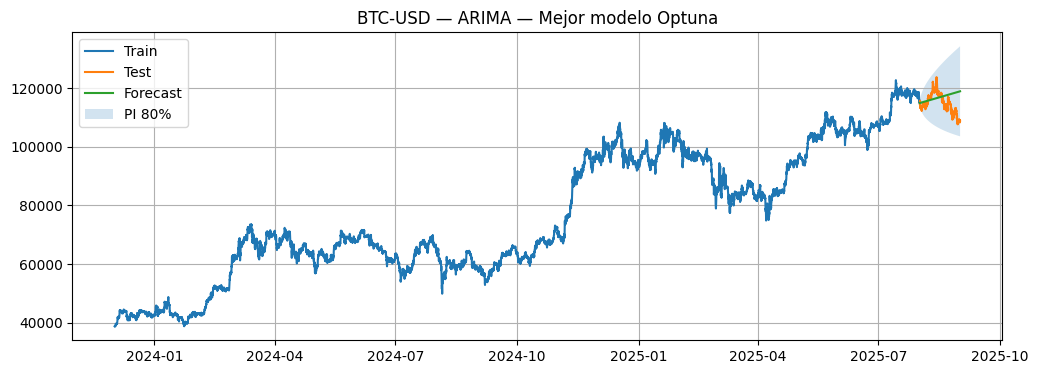

In [15]:
# 1) Descargar datos
df = download_yf_max(TICKER, INTERVAL, auto_adjust=True)
if df is None or df.empty:
    raise RuntimeError("No se obtuvieron datos del instrumento/intervalo elegido.")

# 2) Usamos 'Close' como serie objetivo
if isinstance(df.columns, pd.MultiIndex):
    # yfinance multi-index (e.g., si bajas múltiples tickers)
    if ("Close", TICKER) in df.columns:
        close_col = ("Close", TICKER)
    else:
        # toma el primer 'Close' disponible
        close_candidates = [c for c in df.columns if isinstance(c, tuple) and c[0]=="Close"]
        close_col = close_candidates[0] if close_candidates else ("Close",)
else:
    close_col = "Close"

y_all = df[close_col].astype(float).rename("y").copy()
y_all = y_all[~y_all.index.duplicated(keep="last")].sort_index()

print(f"Descargados {len(y_all)} puntos para {TICKER} @ {INTERVAL}. Rango: {y_all.index.min()} → {y_all.index.max()}")
display(y_all.tail(5))

# 3) Split
y_train, y_test = make_train_test(y_all, H)
print(f"Tamaño train: {len(y_train)}  |  test: {len(y_test)}")

# 4) Optuna
objective, seasonality = objective_factory(y_train, INTERVAL, MODEL_TYPE)
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

print("\nMejores hiperparámetros:", study.best_trial.params)
print("Mejor sMAPE (validación):", study.best_value)

# 5) Reentrenar en todo el train con los mejores hiperparámetros y predecir H
bp = study.best_trial.params
p, d, q = bp["p"], bp["d"], bp["q"]
if MODEL_TYPE.lower() == "sarimax":
    P, D, Q = bp.get("P",0), bp.get("D",0), bp.get("Q",0)
    s_season = seasonality
else:
    P=D=Q=0
    s_season = 0

model = SARIMAX(
    y_train.values,
    order=(p,d,q),
    seasonal_order=(P,D,Q,s_season) if s_season>0 else (0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False, maxiter=300)

fc = res.get_forecast(steps=len(y_test))
mean = pd.Series(fc.predicted_mean, index=y_test.index, name="forecast")
conf = fc.conf_int(alpha=0.2)  # 80% PI
if conf is None:
    lower = upper = None
else:
    # convierte a ndarray si viene como DataFrame
    try:
        conf_np = conf.to_numpy()
        ci_index = getattr(conf, "index", None)
    except Exception:
        conf_np = np.asarray(conf)
        ci_index = None

    if conf_np.ndim == 2 and conf_np.shape[1] >= 2:
        lower = conf_np[:, 0]
        upper = conf_np[:, 1]
    else:
        lower = upper = None

# (opcional) asegurar longitudes correctas para el plot
if lower is not None and len(lower) != len(mean):
    lower = lower[:len(mean)]
    upper = upper[:len(mean)]

# 6) Métricas
metrics = summarize_metrics(y_train.values, y_test.values, mean.values, lower, upper, seasonality=seasonality)
metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
display(metrics_df)

print("\nResumen métricas:")
for k,v in metrics.items():
    if v is None:
        print(f"  {k:12}: {v}")
    else:
        try:
            print(f"  {k:12}: {v:.6f}")
        except Exception:
            print(f"  {k:12}: {v}")

# Plot
plt.figure()
plt.plot(y_train.index, y_train.values, label="Train")
plt.plot(y_test.index, y_test.values, label="Test")
plt.plot(mean.index, mean.values, label="Forecast")
if lower is not None and upper is not None:
    plt.fill_between(mean.index, lower, upper, alpha=0.2, label="PI 80%")
plt.title(f"{TICKER} — {MODEL_TYPE.upper()} — Mejor modelo Optuna")
plt.legend()
plt.show()


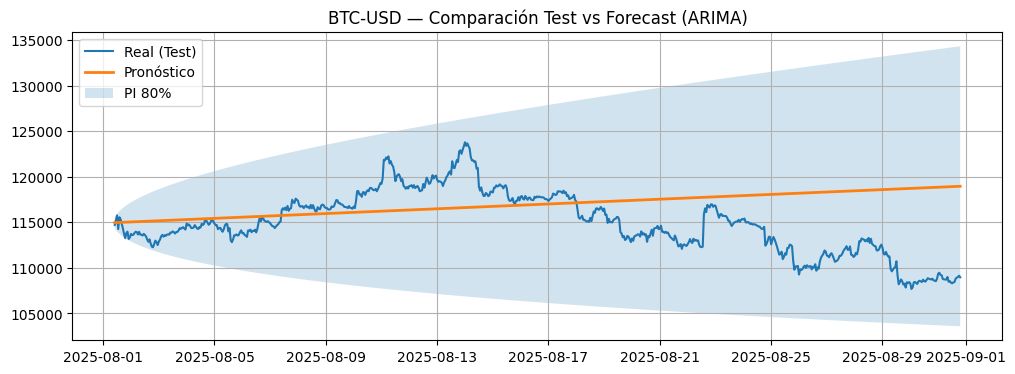

In [16]:
# Asegurar que lower/upper existan y se alineen
lo = None if 'lower' not in globals() or lower is None else np.asarray(lower)
up = None if 'upper' not in globals() or upper is None else np.asarray(upper)

# Recorte defensivo si el largo difiere
if lo is not None and len(lo) != len(mean):
    lo = lo[:len(mean)]
    up = up[:len(mean)] if up is not None else None

plt.figure()
plt.plot(y_test.index, y_test.values, label="Real (Test)")
plt.plot(mean.index, mean.values, label="Pronóstico", linewidth=2)
if lo is not None and up is not None:
    plt.fill_between(mean.index, lo, up, alpha=0.2, label="PI 80%")
plt.title(f"{TICKER} — Comparación Test vs Forecast ({MODEL_TYPE.upper()})")
plt.legend()
plt.grid(True)
plt.show()
